In [1]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
from tqdm import tqdm
import seaborn as sns
from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [2]:
from underwriting import data_quality_checks

# Step0

Move global variables to a separate util file and can be changed for future parameter changes

In [3]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
CURRENT_MONTH = '2022-01'

In [4]:
company_identifier_list = ['RA','HPCC','SFVPC','EMA','EMF','EMM','EMT','GRG','ST','EL']

# Step1

1. Create functions to first extract every company's incoming and outgoing transaction data
2. Find the cost per unit for each sale 
3. Find the mean/var for each product category (verifying distributions via histgram plots) 
4. Group by product category and plot boxplot for each category (separate or combined by company)
5. Group by state and product category and boxplot (separate or combined by company)
6. Group by month and product category and plot line plot with 95% CI shades over time

In [5]:
def fetch_data(company_identifier,transfer_packages_start_date,sales_transactrions_start_date,current_month):
    df_in,df_sales_deduped,bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts = data_quality_checks.run(company_identifier,transfer_packages_start_date,sales_transactrions_start_date)    
    return df_in,df_sales_deduped
    

In [6]:
###test out
incoming_transfer_data,sales_transaction_deduped = fetch_data(tuple(['EL']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,CURRENT_MONTH)


c:\users\roy luo\appdata\local\programs\python\python38\lib\site-packages\google\cloud\bigquery\client.py:535: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


Verifying download summaries for license C9-0000370-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-21

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 22 (0.11245144142302188%)
# transactions total: 19564
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 7652


In [7]:
sales_transaction_deduped.sort_values('sales_datetime', inplace=True)

In [8]:
sales_transaction_deduped.head()

,license_number,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price
19563,C9-0000370-LIC,0047837378,active,Consumer,2020-09-10 19:10:17+00:00,2020-09,3,99.0,active,7737293,1A4060300004975000097144,Buddies - Purple Zkittles - 1g Distillate Vape...,Vape Cartridge (weight - each),Each,1.0,36.0
19562,C9-0000370-LIC,0047837378,active,Consumer,2020-09-10 19:10:17+00:00,2020-09,3,99.0,active,7737386,1A4060300004975000097131,Buddies - Blue Dream X Lemon Zest - 1g CDT Dis...,Vape Cartridge (weight - each),Each,1.0,36.0
19561,C9-0000370-LIC,0047837378,active,Consumer,2020-09-10 19:10:17+00:00,2020-09,3,99.0,active,7548982,1A40603000092E5000080140,Higher: 100mg Crackers (10 Pack): Rosemary Garlic,Edible (weight - each),Each,1.0,27.0
19560,C9-0000370-LIC,0048039327,active,Consumer,2020-09-11 17:02:05+00:00,2020-09,2,81.0,active,7737292,1A4060300004975000097145,Buddies - Peach Flambe X Pineapple Upside Down...,Vape Cartridge (weight - each),Each,1.0,40.5
19559,C9-0000370-LIC,0048039327,active,Consumer,2020-09-11 17:02:05+00:00,2020-09,2,81.0,active,7737296,1A4060300004975000097138,Buddies - Orange Creamsicle - 1g Liquid Diamon...,Vape Cartridge (weight - each),Each,1.0,40.5


In [9]:
sales_transaction_deduped.dtypes

license_number                           object
receipt_number                           object
rt_type                                  object
sales_customer_type                      object
sales_datetime              datetime64[ns, UTC]
sales_month                              object
total_packages                            int64
rt_total_price                          float64
tx_type                                  object
tx_package_id                            object
tx_package_label                         object
tx_product_name                          object
tx_product_category_name                 object
tx_unit_of_measure                       object
tx_quantity_sold                        float64
tx_total_price                          float64
dtype: object

In [10]:
sales_transaction_deduped.shape

(19564, 16)

In [11]:
sales_transaction_deduped.tx_product_category_name.value_counts()

Vape Cartridge (weight - each)         3612
Edible (weight - each)                 3368
Flower (packaged eighth - each)        2875
Vape Cartridge (volume - each)         2328
Pre-Roll Flower                        1634
Extract (weight - each)                1123
Flower (packaged quarter - each)        737
Pre-Roll Infused                        615
Capsule (weight - each)                 454
Flower (packaged half ounce - each)     452
Flower (packaged gram - each)           444
Pre-Roll Leaf                           441
Other Concentrate (weight - each)       380
Tincture (volume - each)                343
Flower (packaged - each)                314
Flower (packaged ounce - each)          150
Topical (volume - each)                 134
Shake (Packaged Half Ounce - each)       53
Edible (volume - each)                   35
Flower                                   30
Tincture (weight - each)                 24
Extract (volume - each)                  12
Topical (weight - each)         

In [12]:
sales_transaction_deduped.sales_customer_type.value_counts()

Consumer    19417
Patient       147
Name: sales_customer_type, dtype: int64

In [13]:
sales_transaction_deduped['tx_price_per_unit'] = sales_transaction_deduped.tx_total_price / sales_transaction_deduped.tx_quantity_sold
sales_transaction_deduped['date_in_month'] = sales_transaction_deduped.sales_datetime.dt.strftime('%Y-%m')


c:\users\roy luo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tx_price_per_unit'>

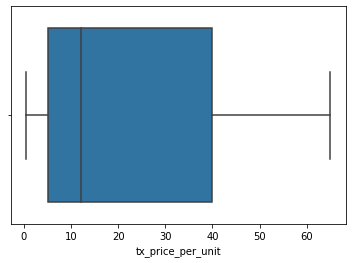

In [14]:
sns.boxplot(sales_transaction_deduped[sales_transaction_deduped.tx_product_category_name == 'Pre-Roll Flower']['tx_price_per_unit'])

<AxesSubplot:xlabel='tx_price_per_unit', ylabel='tx_product_category_name'>

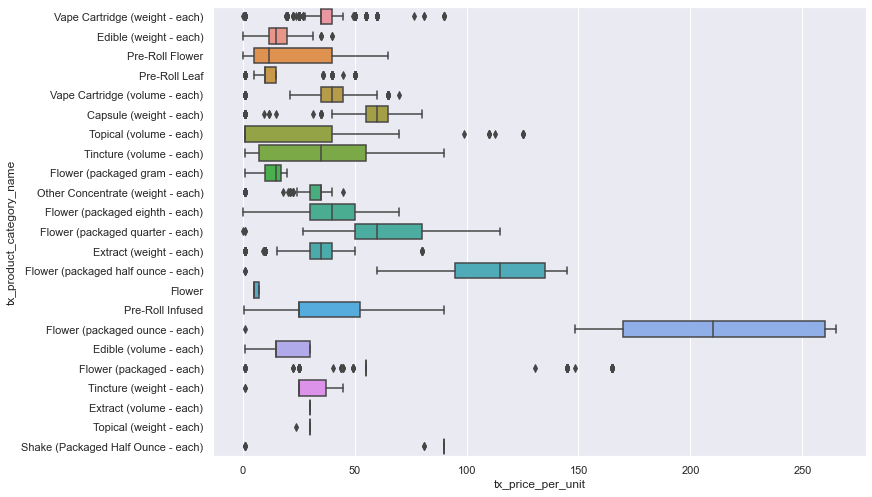

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y="tx_product_category_name", x="tx_price_per_unit", data=sales_transaction_deduped, orient = 'h')


Total number of transactions: 1634
Number of transactions outliers below Boxplot Whisker Minimum is 0.0 %
Number of transactions outliers above Boxplot Whisker Maximum is 0.004895960832313341 %


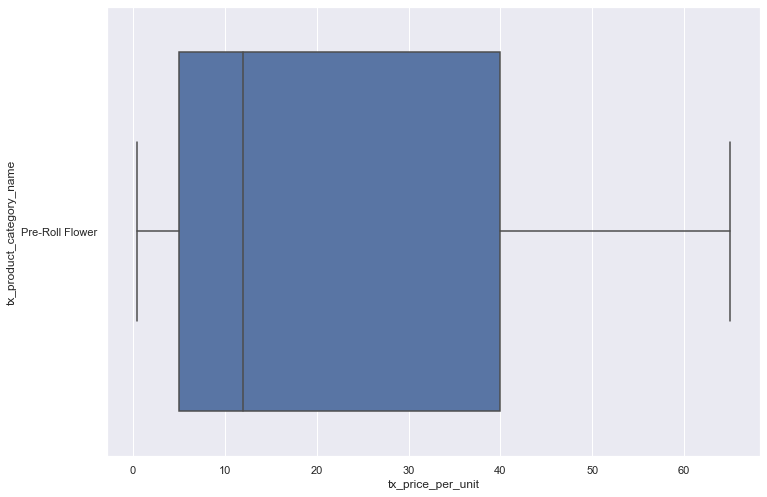

In [16]:
temp_df = sales_transaction_deduped[sales_transaction_deduped['tx_product_category_name'] == 'Pre-Roll Flower']
sns.boxplot(y="tx_product_category_name", x="tx_price_per_unit", data=temp_df, orient = 'h')

median = temp_df.tx_price_per_unit.median()
q1 = temp_df.tx_price_per_unit.quantile(.25)
q3 = temp_df.tx_price_per_unit.quantile(.75)
iqr = q3 - q1
maxx = median + iqr * 1.5
minn = median - iqr * 1.5

print("Total number of transactions: {}".format(temp_df.shape[0]))
print("Number of transactions outliers below Boxplot Whisker Minimum is {} %".format((temp_df.tx_price_per_unit < minn).mean()))
print("Number of transactions outliers above Boxplot Whisker Maximum is {} %".format((temp_df.tx_price_per_unit > maxx).mean()))

Vape Cartridge (weight - each)
3612


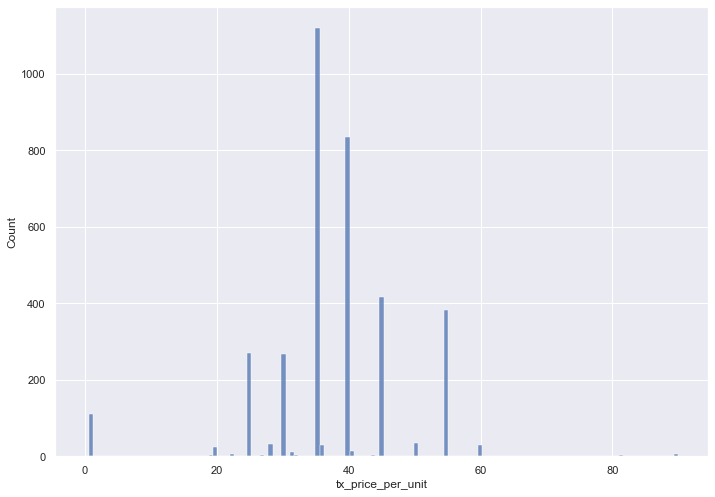

Edible (weight - each)
3368


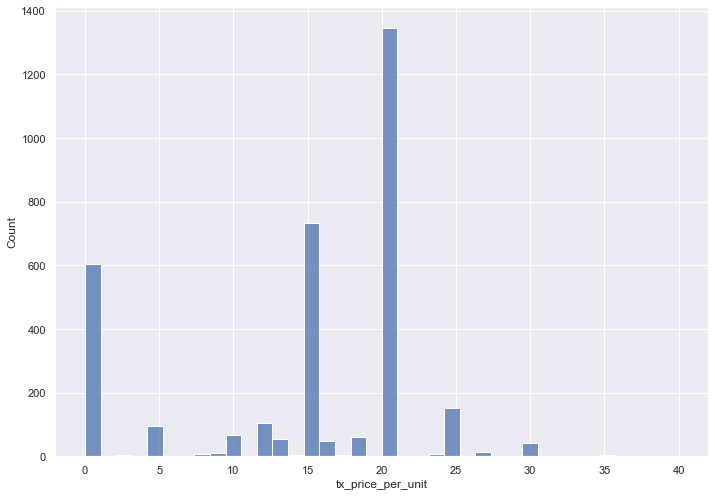

Pre-Roll Flower
1634


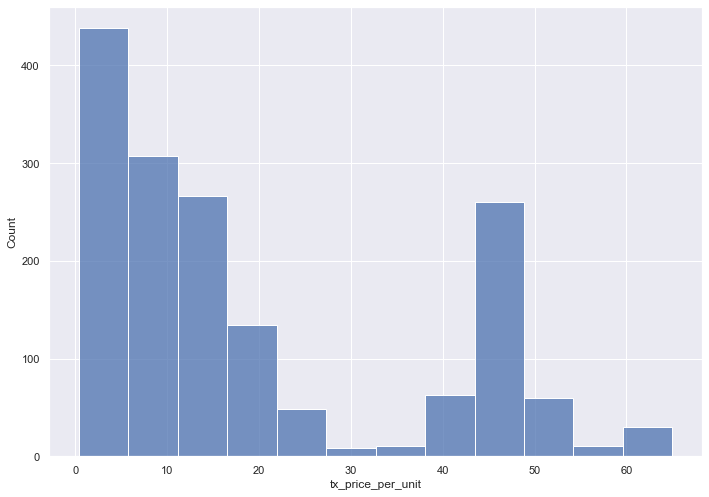

Pre-Roll Leaf
441


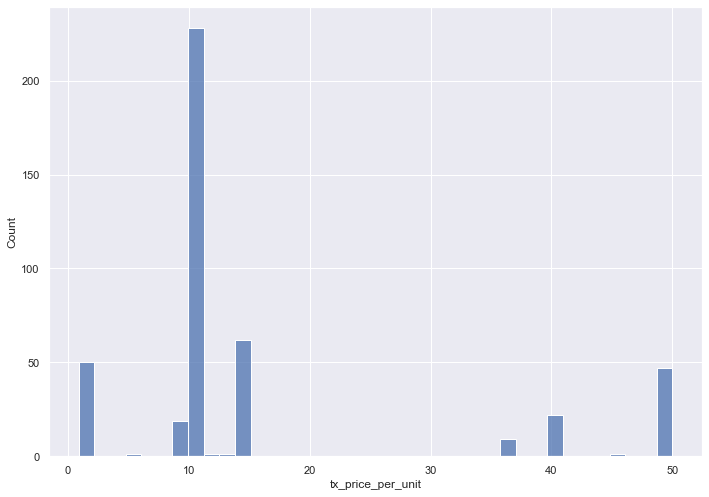

Vape Cartridge (volume - each)
2328


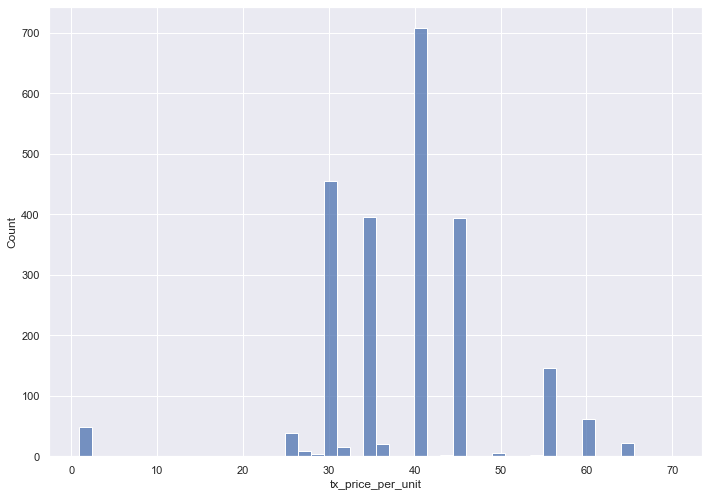

Capsule (weight - each)
454


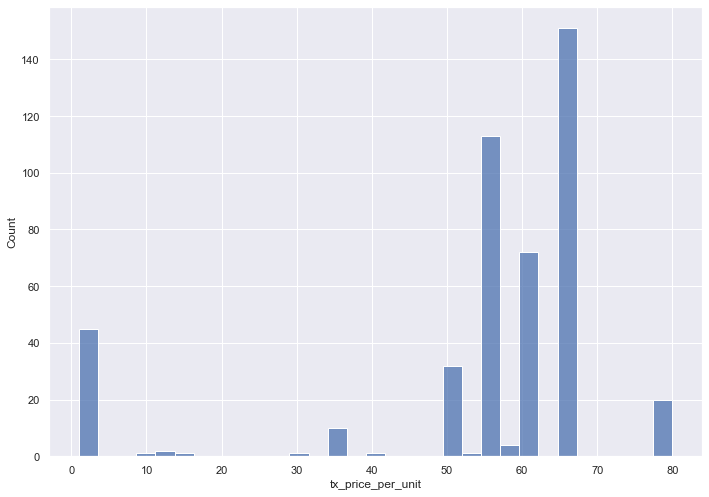

Topical (volume - each)
134


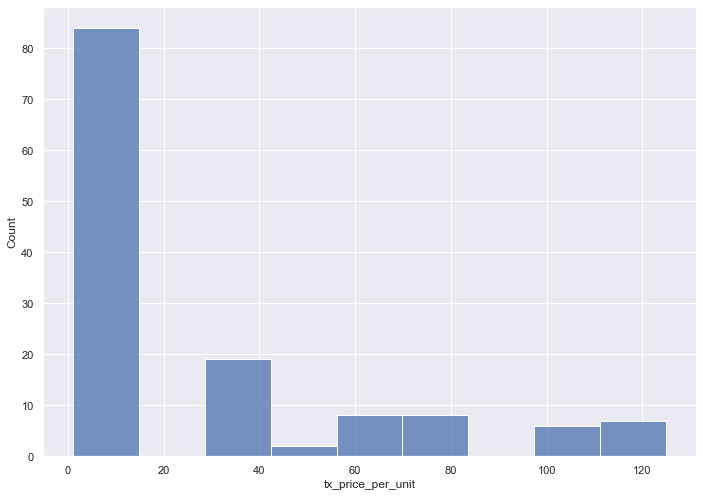

Tincture (volume - each)
343


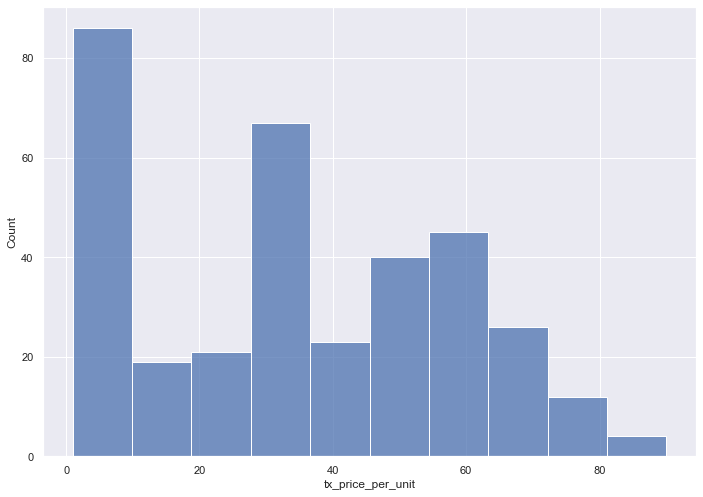

Flower (packaged gram - each)
444


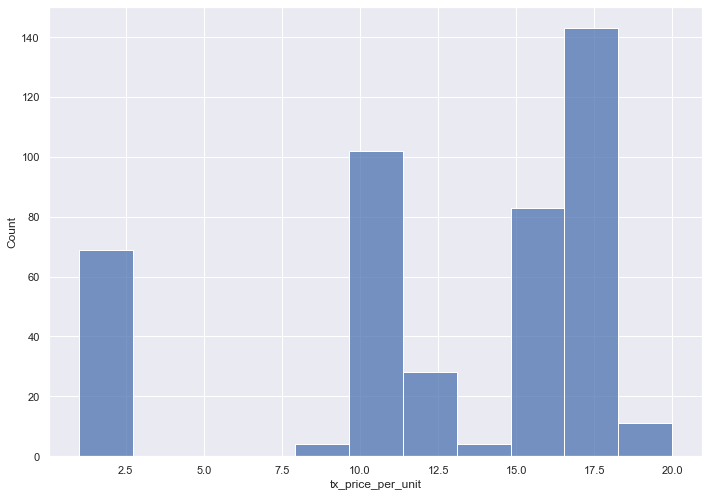

Other Concentrate (weight - each)
380


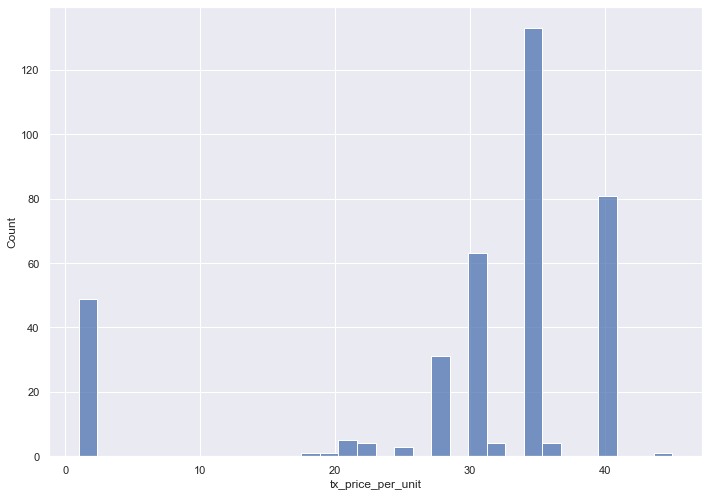

Flower (packaged eighth - each)
2875


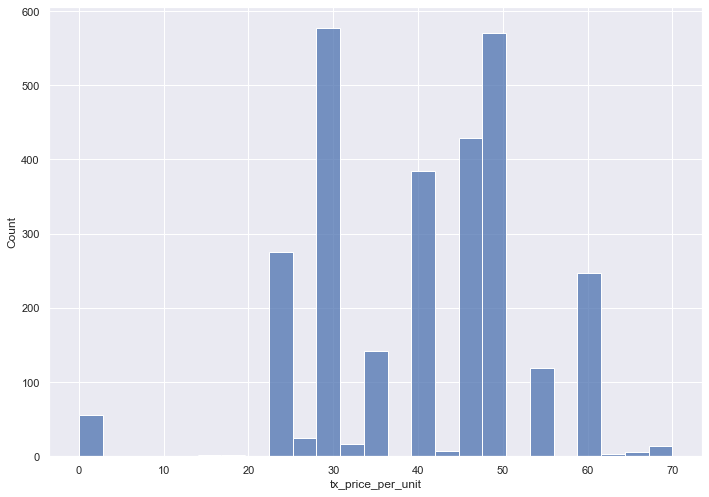

Flower (packaged quarter - each)
737


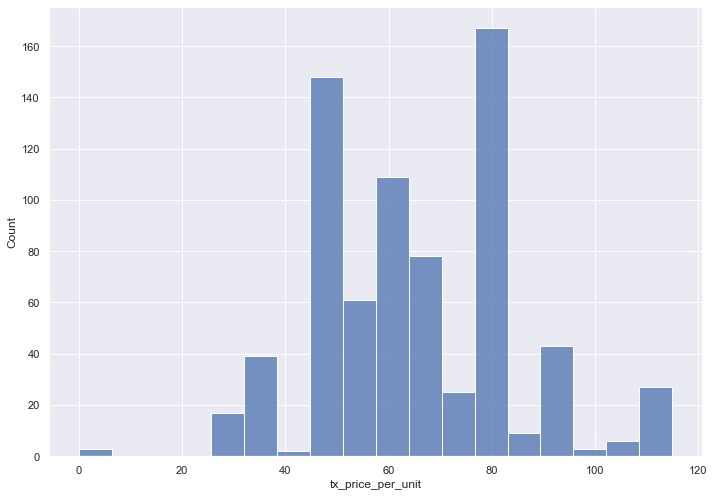

Extract (weight - each)
1123


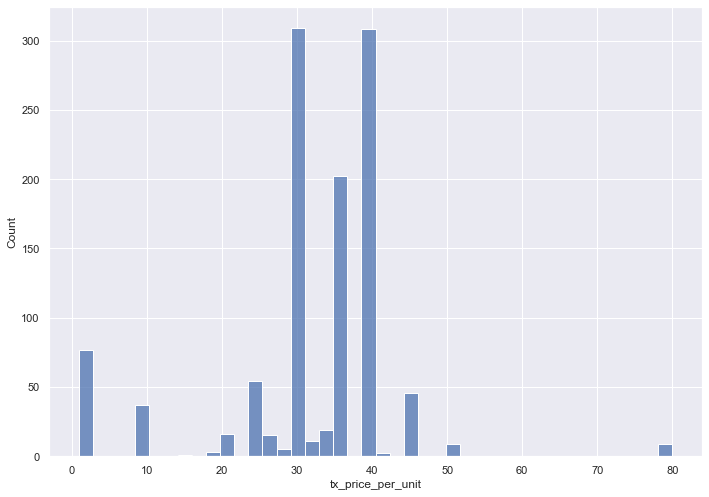

Flower (packaged half ounce - each)
452


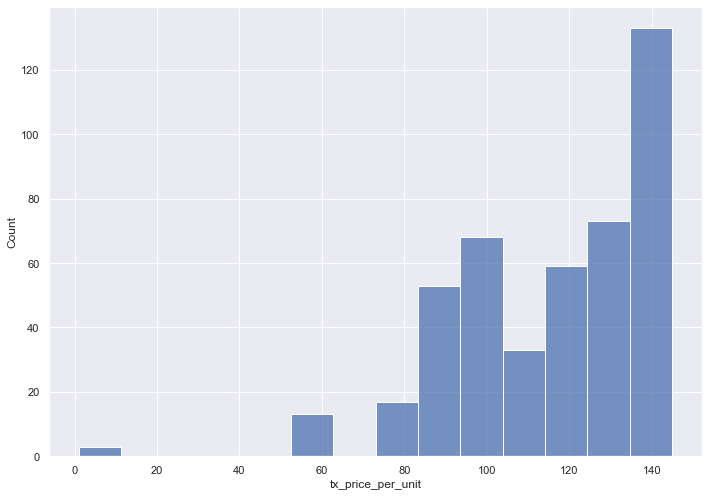

Flower
30


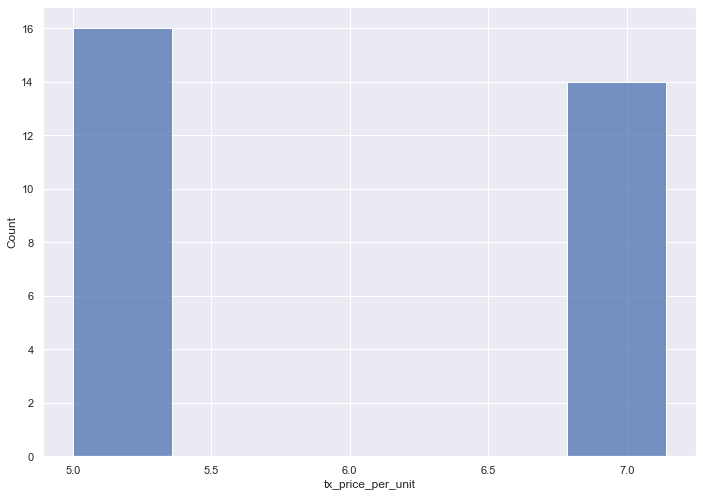

Pre-Roll Infused
615


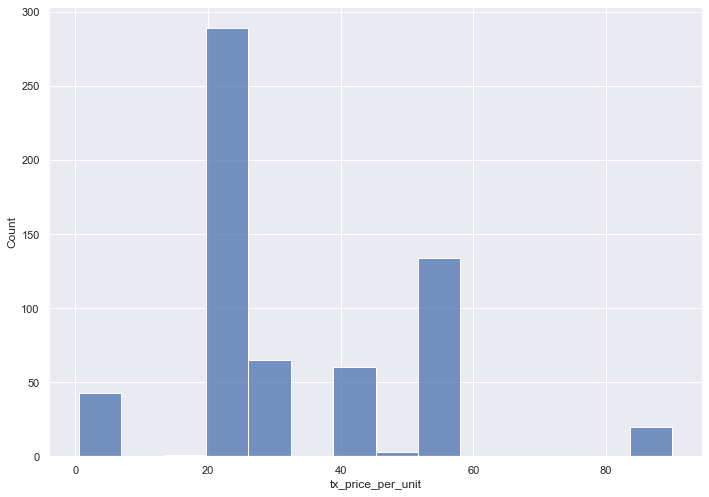

Flower (packaged ounce - each)
150


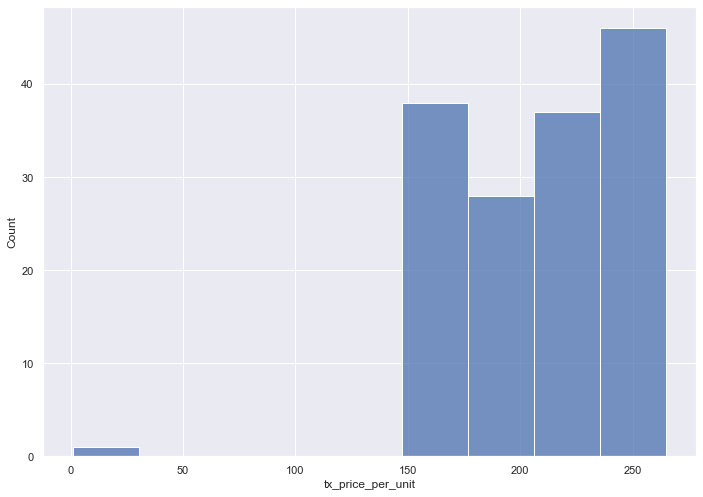

Edible (volume - each)
35


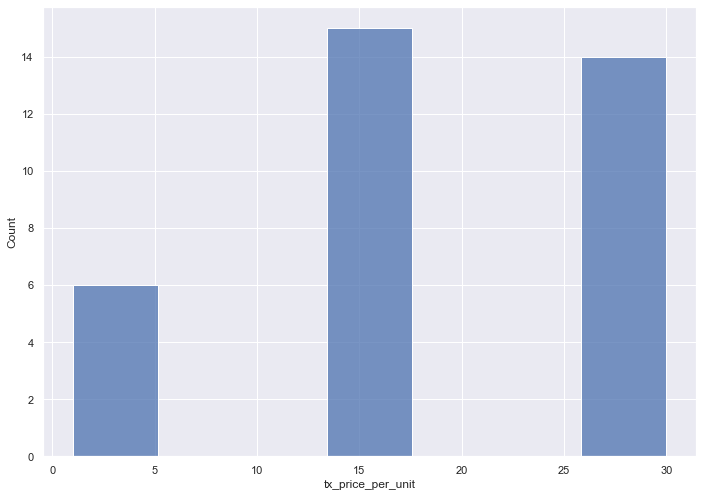

Flower (packaged - each)
314


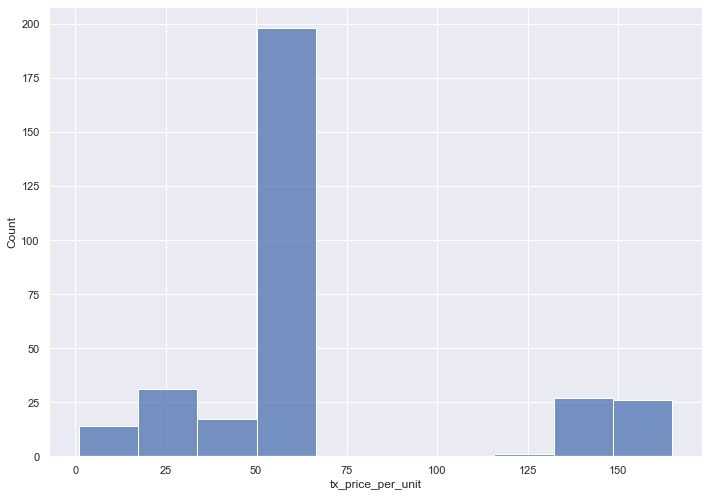

Tincture (weight - each)
24


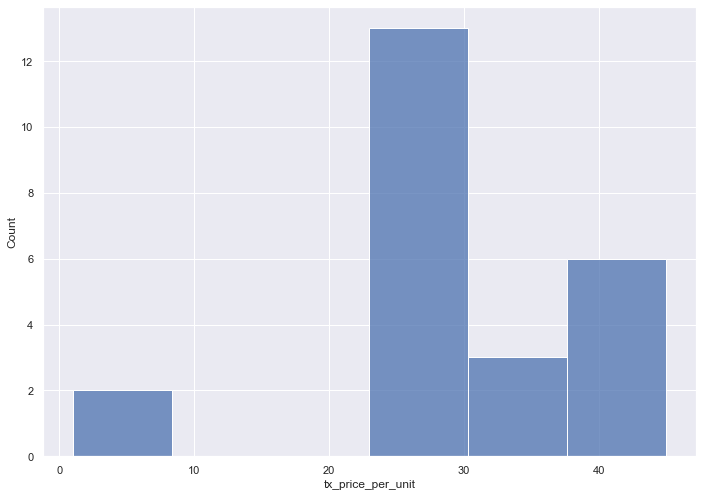

Extract (volume - each)
12


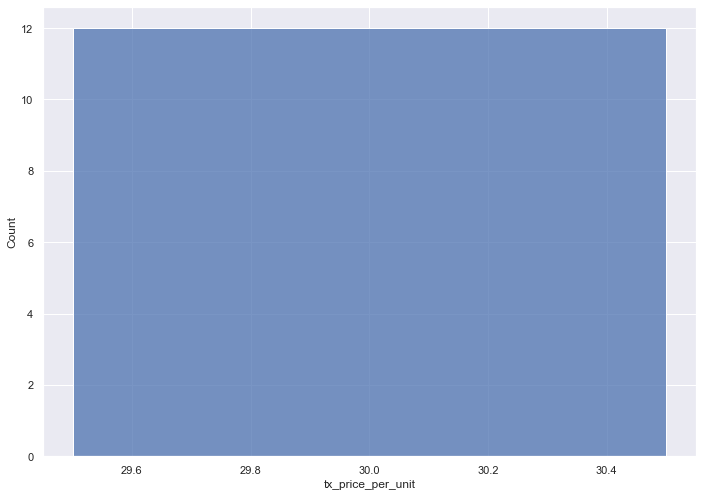

Topical (weight - each)
6


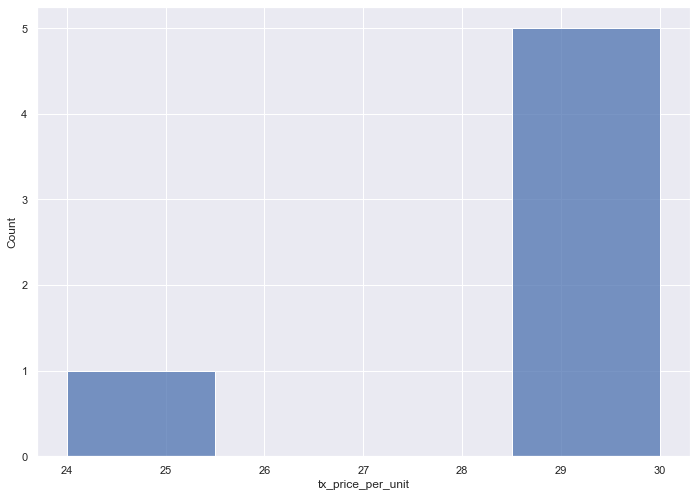

Shake (Packaged Half Ounce - each)
53


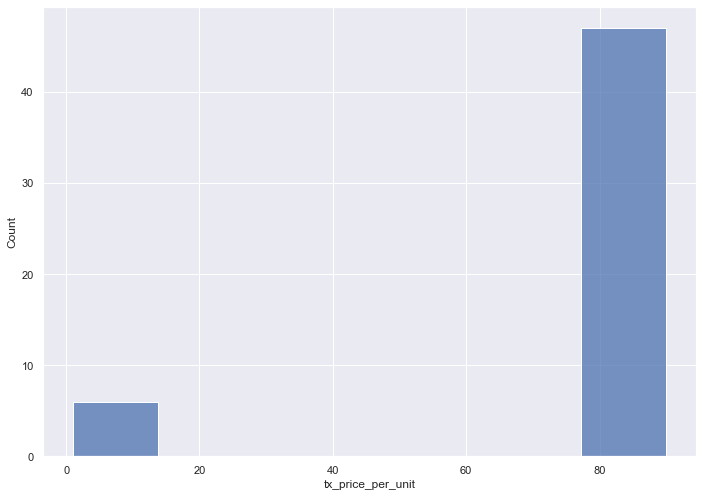

In [17]:
for product in sales_transaction_deduped.tx_product_category_name.unique():
    print(product)
    print(sum(sales_transaction_deduped.tx_product_category_name == product))
    sns.histplot(data=sales_transaction_deduped[sales_transaction_deduped.tx_product_category_name == product], x="tx_price_per_unit");
    plt.show()

In [18]:
msrp_tables = sales_transaction_deduped.groupby('tx_product_category_name')['tx_price_per_unit'].describe()#.unstack(1)
msrp_tables

,count,mean,std,min,25%,50%,75%,max
tx_product_category_name,,,,,,,,
Capsule (weight - each),454.0,53.636784,19.530003,1.00,55.00,60.000,65.000000,80.000000
Edible (volume - each),35.0,18.471429,10.607255,1.00,15.00,15.000,30.000000,30.000000
Edible (weight - each),3368.0,14.757675,7.641704,0.00,12.00,15.125,20.000000,40.000000
Extract (volume - each),12.0,30.000000,0.000000,30.00,30.00,30.000,30.000000,30.000000
Extract (weight - each),1123.0,31.788753,11.665182,0.90,30.00,35.000,40.000000,80.000000
Flower,30.0,6.000000,1.087321,5.00,5.00,5.000,7.142857,7.142857
Flower (packaged - each),314.0,66.230892,42.699541,1.00,55.00,55.000,55.000000,165.000000
Flower (packaged eighth - each),2875.0,40.643659,12.192019,0.00,30.00,40.000,50.000000,70.000000
Flower (packaged gram - each),444.0,12.188401,5.583718,1.00,10.00,15.000,17.000000,20.000000


In [19]:
msrp_tables.loc['Edible (weight - each)']

count    3368.000000
mean       14.757675
std         7.641704
min         0.000000
25%        12.000000
50%        15.125000
75%        20.000000
max        40.000000
Name: Edible (weight - each), dtype: float64

In [21]:
msrp_by_month_product_name = sales_transaction_deduped.groupby(['tx_product_category_name', 'date_in_month'])['tx_price_per_unit'].describe()
msrp_by_month_product_name

count       mean        std  \
tx_product_category_name       date_in_month                                
Capsule (weight - each)        2020-09          3.0  53.166667   3.175426   
                               2020-10         17.0  51.735294  19.880202   
                               2020-11          9.0  58.333333   5.000000   
                               2020-12         25.0  64.840000  17.374982   
                               2021-01         13.0  72.692308  10.127394   
...                                             ...        ...        ...   
Vape Cartridge (weight - each) 2021-10        219.0  41.296804  10.900237   
                               2021-11        298.0  37.993020  10.555812   
                               2021-12        487.0  39.530801  11.823073   
                               2022-01        465.0  38.487097  10.225046   
                               2022-02        285.0  38.799298  11.025048   

                                               min    25%   50%   75%   max  
tx_product_category_name       date_in_month                                 
Capsule (weight - each)        2020-09        49.5  52.25  55.0  55.0  55.0  
                               2020-10         1.0  55.00  55.0  65.0  65.0  
                               2020-11        55.0  55.00  55.0  65.0  65.0  
                               2020-12         1.0  55.00  65.0  80.0  80.0  
                               2021-01        55.0  65.00  80.0  80.0  80.0  
...                                            ...    ...   ...   ...   ...  
Vape Cartridge (weight - each) 2021-10         0.0  35.00  35.0  55.0  60.0  
                               2021-11         1.0  35.00  35.0  40.0  60.0  
                               2021-12         1.0  35.00  40.0  45.0  60.0  
                               2022-01         1.0  35.00  36.0  40.0  60.0  
                               2022-02         1.0  35.00  35.0  40.0  60.0  

[333 rows x 8 columns]

In [22]:
msrp_product_temp = msrp_by_month_product_name.loc['Edible (weight - each)']
msrp_product_temp

,count,mean,std,min,25%,50%,75%,max
date_in_month,,,,,,,,
2020-09,27.0,11.568148,8.952170,0.01,1.0,13.5,17.0,30.0
2020-10,80.0,15.901042,6.333321,1.00,15.0,15.0,20.0,40.0
2020-11,95.0,16.659649,7.575932,1.00,15.0,20.0,20.0,40.0
2020-12,164.0,16.516768,6.689552,1.00,15.0,20.0,20.0,30.0
2021-01,164.0,14.271341,7.624096,1.00,10.0,15.0,20.0,30.0
2021-02,153.0,14.751634,6.891099,1.00,13.5,15.0,20.0,30.0
2021-03,153.0,13.453464,7.428106,0.60,10.0,15.0,20.0,31.5
2021-04,187.0,14.820856,7.854395,1.00,12.0,15.0,20.0,35.0
2021-05,199.0,15.482412,7.268198,1.00,15.0,16.0,20.0,27.0


<AxesSubplot:xlabel='date_in_month'>

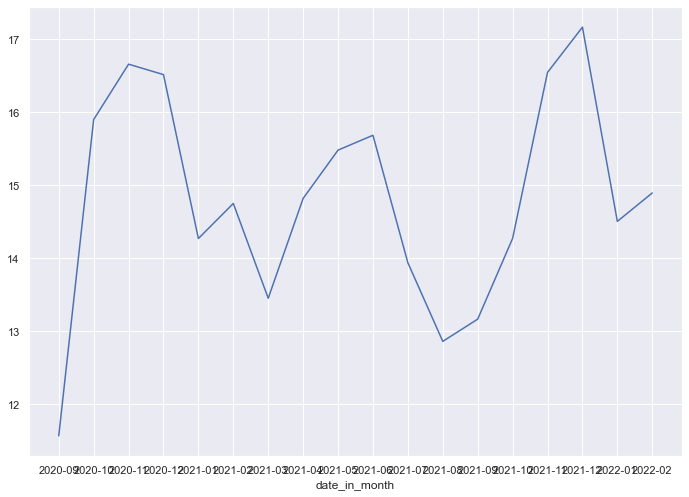

In [23]:
sns.lineplot(data = msrp_product_temp, x = msrp_product_temp.index, y = msrp_product_temp['mean'].values)

<AxesSubplot:xlabel='date_in_month', ylabel='tx_price_per_unit'>

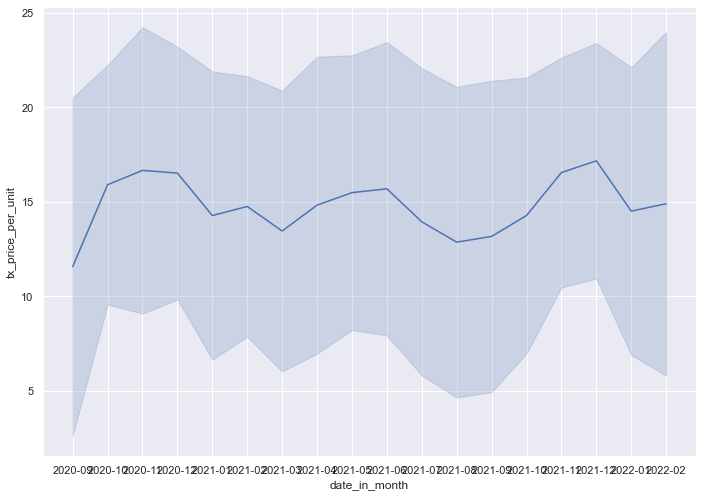

In [24]:
sns.lineplot(data = sales_transaction_deduped[sales_transaction_deduped.tx_product_category_name == 'Edible (weight - each)'], x = 'date_in_month', y = 'tx_price_per_unit',ci = 'sd')

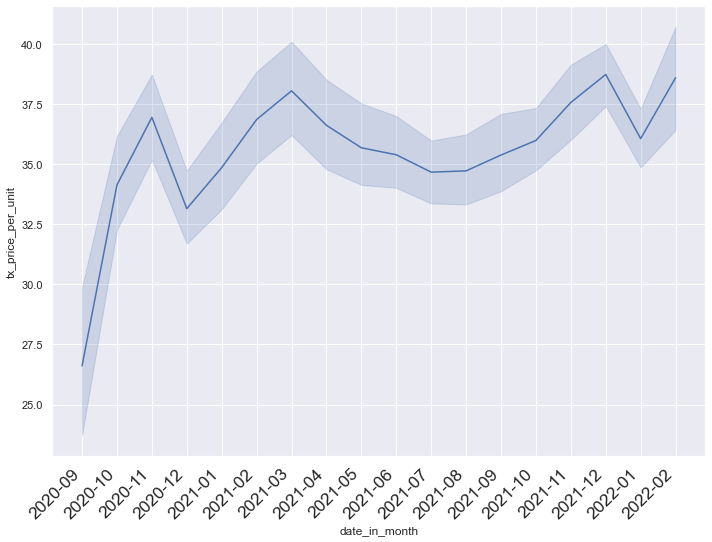

In [41]:
ax = sns.lineplot(data = sales_transaction_deduped, x = 'date_in_month', y = 'tx_price_per_unit',ci = 95,
                  err_style = 'band')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

# Step2

1. Add some functionality to combine some product categories that are similar but varies in unit (Flower packaged gram vs packaged half ounce) -- need to use regular expression
2. Add functionality for more granular product name/product brand breakdown on top of product category -- need regular expression for product brand

# Step3

Final output for base analysis
1. Plots
2. Filtered data
3. Table with numbers

# Step4

Time series forecasting for future MSRP to understand future price trends